# Feature Engineering with delay sequence data

This notebook will perform feature engineering based on the finding from the "Ultrasonic_EDA_Delay Sequence" notebook. 

In [73]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [74]:
def get_all_files_in_directory(root_directory):
    file_paths = []
    for root, dirs, files in os.walk(root_directory):
        for file in files:
            file_paths.append(os.path.join(root, file))
    return file_paths


def merge_csv_files(file_paths):
    """
    Merge multiple CSV files into a single DataFrame.

    Parameters:
    file_paths (list of str): List of file paths to the CSV files.

    Returns:
    DataFrame: Merged DataFrame containing data from all input CSV files.
    """
    dataframes = []
    for file in file_paths:
        df = pd.read_csv(file)
        dataframes.append(df)

    # Concatenate all DataFrames
    merged_df = pd.concat(dataframes, ignore_index=True)
    
    return merged_df

## Import data

Currently there are 20 sensor datas.

In [75]:
folder_path = '../../ultra_sonic_sensor/fully_automate/data_v4.1.1'
file_paths = get_all_files_in_directory(folder_path)
df_data_v4_1_1 = merge_csv_files(file_paths)
df_data_v4_1_1

,Trial,Ping Duration,Distance (cm),Ping Time (us),Delay (us),Steps,Arduino ID,Sensor ID,Range (cm),Sensor length (cm),...,side a (cm),side b (cm),side c (cm),Angle on YZ plane,Sensor Configuration,Sensor Angle,Surface material,Surface Length (cm),Surface Width (cm),side g (cm)
0,0,3416,13.25,755,16800,11223.0,1,51,13,0.8,...,18.3,18.3,0,0,HTR,90,wood,31,30.5,NaN
1,1,3400,12.82,731,16800,11223.0,1,51,13,0.8,...,18.3,18.3,0,0,HTR,90,wood,31,30.5,NaN
2,2,3432,13.32,759,16800,11223.0,1,51,13,0.8,...,18.3,18.3,0,0,HTR,90,wood,31,30.5,NaN
3,3,3424,13.32,759,16800,11223.0,1,51,13,0.8,...,18.3,18.3,0,0,HTR,90,wood,31,30.5,NaN
4,4,3428,13.25,755,16800,11223.0,1,51,13,0.8,...,18.3,18.3,0,0,HTR,90,wood,31,30.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323896,45,8288,52.96,3019,3000,0.0,1,15,53,0.8,...,18.3,18.3,0,0,HTR,90,wood,31,30.5,NaN
323897,46,8292,53.04,3023,3000,0.0,1,15,53,0.8,...,18.3,18.3,0,0,HTR,90,wood,31,30.5,NaN
323898,47,8292,53.04,3023,3000,0.0,1,15,53,0.8,...,18.3,18.3,0,0,HTR,90,wood,31,30.5,NaN
323899,48,8288,52.96,3019,3000,0.0,1,15,53,0.8,...,18.3,18.3,0,0,HTR,90,wood,31,30.5,NaN


Clean data

In [76]:
# Step 1: Identify Columns with NaNs
nan_columns = df_data_v4_1_1.columns[df_data_v4_1_1.isnull().any()]

# Step 2: Find Mode and Replace NaNs
for col in nan_columns:
    if df_data_v4_1_1[col].dtype == object:  # Check if the column is categorical
        mode_value = df_data_v4_1_1[col].mode()[0]  # Find the mode value (most frequent value)\
        df_data_v4_1_1[col].fillna(mode_value, inplace=True)  # Replace NaNs with the mode value

df_data_v4_1_1["Color of sensor"] = df_data_v4_1_1["Color of sensor"].str.lower()

/var/folders/9b/zsztmz7j6v92l4fdx69q5pxh0000gn/T/ipykernel_48813/1472902145.py:8: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [77]:
values_to_keep = [16800,10000,8000,6000,3000]
df_data_v4_1_1 = df_data_v4_1_1[df_data_v4_1_1["Delay (us)"].isin(values_to_keep)]

# Add IQR Range_delay (Feature Engineering)

Helper codes

In [78]:
def identify_and_remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_no_outliers = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    df_outliers_lower = df[(df[column] <= lower_bound)]
    df_outliers_upper = df[(df[column] >= upper_bound)]
    return df_no_outliers,df_outliers_lower,df_outliers_upper

def split_quartiles(df):
    # Group the data by 'Sensor ID', 'Delay (us)', and 'Range (cm)'
    df_copy = df.copy()
    grouped = df_copy.groupby(['Sensor ID', 'Delay (us)', 'Range (cm)'])

    # Identify and remove outliers for each group
    middle_quartile = []
    lower_quartile = []
    upper_quartile = []

    for name, group in grouped:
        cleaned_group = group.copy()
        for column in ['Ping Time (us)']:
            middle_quartile_group,lower_quartile_group,upper_quartile_group = identify_and_remove_outliers(cleaned_group, column)
        middle_quartile.append(middle_quartile_group)
        lower_quartile.append(lower_quartile_group)
        upper_quartile.append(upper_quartile_group)
    # Combine the cleaned groups into a single DataFrame
    df_middle_quartile= pd.concat(middle_quartile)
    df_lower_quartile = pd.concat(lower_quartile)
    df_upper_quartile = pd.concat(upper_quartile)
    
    return df_middle_quartile, df_lower_quartile, df_upper_quartile


def create_range_delay_feature(df_quartile,bound):
    # Step 1: Group and calculate mean
    df_grouped = df_quartile.groupby(['Sensor ID', 'Range (cm)', 'Delay (us)'])['Ping Time (us)'].mean().reset_index()

    # Step 2: Create `range_delay` column
    df_grouped['range_delay'] = df_grouped['Range (cm)'].astype(str) + '_' + df_grouped['Delay (us)'].astype(str)+'_'+'mean'+'_'+bound

    # Step 3: Pivot the table
    df_pivot = df_grouped.pivot(index='Sensor ID', columns='range_delay', values='Ping Time (us)').reset_index()
    
    return df_pivot

In [79]:
df_middle_quartile, df_lower_quartile, df_upper_quartile = split_quartiles(df_data_v4_1_1)

In [80]:
df_middle_quartile.groupby(['Sensor ID','Range (cm)', 'Delay (us)'])['Ping Time (us)'].mean().reset_index(["Delay (us)","Range (cm)"])

,Range (cm),Delay (us),Ping Time (us)
Sensor ID,,,
1,13,3000,827.000000
1,13,6000,827.000000
1,13,8000,827.000000
1,13,10000,827.000000
1,13,16800,827.000000
...,...,...,...
125,53,3000,3047.000000
125,53,6000,3037.560000
125,53,8000,3037.160000


In [81]:
create_range_delay_feature(df_middle_quartile,"middle")

range_delay,Sensor ID,13_10000_mean_middle,13_16800_mean_middle,13_3000_mean_middle,13_6000_mean_middle,13_8000_mean_middle,18_10000_mean_middle,18_16800_mean_middle,18_3000_mean_middle,18_6000_mean_middle,...,48_10000_mean_middle,48_16800_mean_middle,48_3000_mean_middle,48_6000_mean_middle,48_8000_mean_middle,53_10000_mean_middle,53_16800_mean_middle,53_3000_mean_middle,53_6000_mean_middle,53_8000_mean_middle
0,1,827.000000,827.000000,827.000000,827.000000,827.00000,1071.000000,1069.285714,1069.240000,1069.400000,...,2736.333333,2737.000000,2736.909091,2737.083333,2737.382979,2995.000000,3006.500000,2995.000000,2995.205128,2995.000000
1,2,679.640000,679.000000,679.000000,679.000000,679.00000,943.000000,954.200000,967.260870,954.520000,...,2667.000000,2679.320000,2674.520000,2674.520000,2667.000000,2972.360000,1855.878049,2945.800000,2951.000000,1891.240000
2,3,717.880000,717.727273,718.040000,717.240000,718.04000,1029.933333,1020.920000,1007.000000,1005.960000,...,2709.560000,2721.480000,2717.200000,2717.900000,2716.714286,2996.120000,2992.840000,2995.400000,3000.440000,2997.320000
3,4,737.080000,736.840000,737.160000,736.920000,736.68000,1030.351351,1031.000000,1028.840000,1087.000000,...,2754.040000,2753.800000,2754.120000,2755.000000,2754.200000,2999.000000,2999.608696,2999.000000,2999.000000,2999.000000
4,5,743.000000,742.894737,741.880000,743.000000,743.00000,1046.102041,1045.697674,1047.244898,1046.288889,...,2732.520000,2732.181818,2732.600000,2732.520000,2732.600000,3073.612245,3058.440000,3045.468085,3034.760000,2110.760000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,121,742.200000,751.545455,751.000000,751.000000,741.56000,1045.160000,1051.880000,1046.473684,1046.680000,...,2733.880000,2728.360000,2732.680000,2734.360000,2729.640000,3012.684211,3025.400000,3039.711111,3025.480000,3026.760000
120,122,735.000000,23719.700000,735.244898,735.000000,735.00000,1017.400000,1024.600000,1028.440000,1028.680000,...,2726.520000,2731.480000,2737.042553,2737.400000,2735.000000,3035.000000,3030.666667,3034.800000,3025.000000,3035.756757
121,123,751.000000,747.333333,725.829268,751.000000,751.00000,1043.571429,1043.000000,1043.000000,1043.000000,...,2736.600000,2740.200000,2739.640000,2736.280000,2747.105263,3056.280000,3059.240000,3036.200000,3038.040000,3037.160000
122,124,708.680000,365.222222,708.520000,708.306122,708.44000,1026.280000,1017.560000,1027.880000,1027.000000,...,2726.024390,2714.760000,2716.040000,2714.280000,2715.560000,3018.659574,3019.235294,3010.680000,3019.765957,3020.244444


In [82]:
def feature_engineering_quartile_means(df):
    df_middle_quartile, df_lower_quartile, df_upper_quartile = split_quartiles(df)
    df_range_delay_middle = create_range_delay_feature(df_middle_quartile,"middle")
    df_range_delay_lower = create_range_delay_feature(df_lower_quartile,"lower")
    df_range_delay_upper = create_range_delay_feature(df_upper_quartile,"upper")

    # List of DataFrames
    df_pivots = [df_range_delay_middle, df_range_delay_lower, df_range_delay_upper]

    # Initialize the merged DataFrame with the first DataFrame in the list
    df_range_delay_all = df_pivots[0]

    # Iteratively merge each DataFrame in the list
    for df in df_pivots[1:]:
        df_range_delay_all = df_range_delay_all.merge(df, on='Sensor ID')
        
    # Replace all NaN values with 0 in the merged DataFrame
    df_range_delay_all.fillna(0, inplace=True)

    return df_range_delay_all, df_range_delay_middle, df_range_delay_lower,df_range_delay_upper
    

df_range_delay_all,df_range_delay_middle, df_range_delay_lower,df_range_delay_upper = feature_engineering_quartile_means(df_data_v4_1_1)


The product is following now we will be conducting PCA method to reduce dimensionality

In [83]:
df_range_delay_all

range_delay,Sensor ID,13_10000_mean_middle,13_16800_mean_middle,13_3000_mean_middle,13_6000_mean_middle,13_8000_mean_middle,18_10000_mean_middle,18_16800_mean_middle,18_3000_mean_middle,18_6000_mean_middle,...,48_10000_mean_upper,48_16800_mean_upper,48_3000_mean_upper,48_6000_mean_upper,48_8000_mean_upper,53_10000_mean_upper,53_16800_mean_upper,53_3000_mean_upper,53_6000_mean_upper,53_8000_mean_upper
0,1,827.000000,827.000000,827.000000,827.000000,827.00000,1071.000000,1069.285714,1069.240000,1069.400000,...,2795.000000,0.0,2809.4,2803.000000,2800.333333,2995.545455,0.000000,2995.444444,3039.727273,3004.043478
1,2,679.640000,679.000000,679.000000,679.000000,679.00000,943.000000,954.200000,967.260870,954.520000,...,2669.521739,0.0,0.0,0.000000,2691.000000,0.000000,2371.000000,0.000000,2951.744186,0.000000
2,3,717.880000,717.727273,718.040000,717.240000,718.04000,1029.933333,1020.920000,1007.000000,1005.960000,...,0.000000,0.0,2743.0,2727.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,4,737.080000,736.840000,737.160000,736.920000,736.68000,1030.351351,1031.000000,1028.840000,1087.000000,...,0.000000,0.0,0.0,2755.195122,0.000000,3000.000000,3019.000000,3000.116279,2999.930233,3000.116279
4,5,743.000000,742.894737,741.880000,743.000000,743.00000,1046.102041,1045.697674,1047.244898,1046.288889,...,0.000000,2755.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,121,742.200000,751.545455,751.000000,751.000000,741.56000,1045.160000,1051.880000,1046.473684,1046.680000,...,0.000000,0.0,0.0,0.000000,0.000000,3037.666667,0.000000,3057.000000,0.000000,0.000000
120,122,735.000000,23719.700000,735.244898,735.000000,735.00000,1017.400000,1024.600000,1028.440000,1028.680000,...,0.000000,0.0,2765.0,0.000000,2736.128205,3043.000000,0.000000,3059.000000,0.000000,3043.000000
121,123,751.000000,747.333333,725.829268,751.000000,751.00000,1043.571429,1043.000000,1043.000000,1043.000000,...,0.000000,0.0,0.0,0.000000,2759.000000,0.000000,0.000000,0.000000,0.000000,0.000000
122,124,708.680000,365.222222,708.520000,708.306122,708.44000,1026.280000,1017.560000,1027.880000,1027.000000,...,0.000000,0.0,0.0,0.000000,0.000000,3027.000000,3044.333333,0.000000,3047.000000,0.000000


## Conduct PCA based feature importance

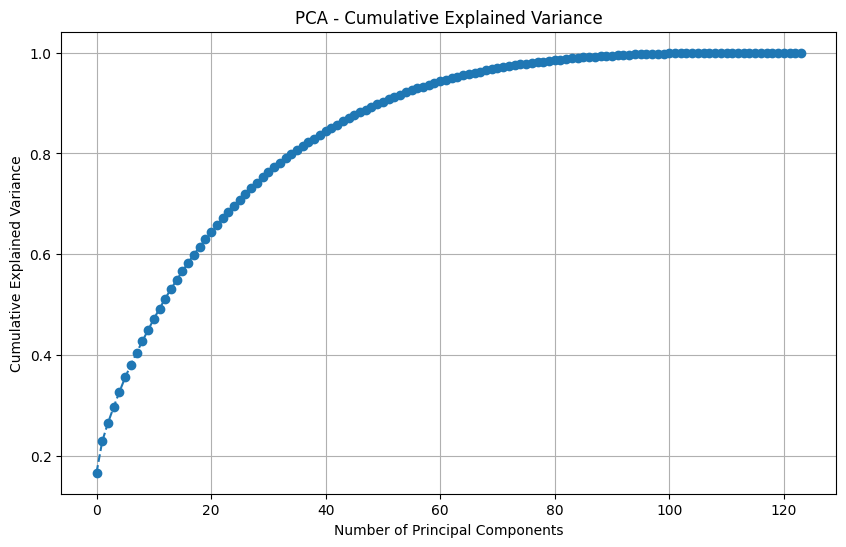

In [84]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def process_PCA(df):
    # Extract features and standardize
    features = df.drop(columns='Sensor ID')
    sensor_ids = df['Sensor ID']

    # Standardize the features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Perform PCA
    pca = PCA()
    principal_components = pca.fit_transform(features_scaled)

    # Explained variance ratio for each principal component
    explained_variance = pca.explained_variance_ratio_

    # Plot the explained variance to see the importance of each component
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(explained_variance), marker='o', linestyle='--')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA - Cumulative Explained Variance')
    plt.grid(True)
    plt.show()

    # Get the loadings (coefficients) of the features on the principal components
    loadings = pca.components_

    # Display the loadings for the first few principal components
    return explained_variance, loadings, features

explained_variance, loadings, features = process_PCA(df_range_delay_all)



In [85]:
# Create a DataFrame for the loadings
loading_df = pd.DataFrame(loadings.T, columns=[f'PC{i+1}' for i in range(loadings.shape[0])], index=features.columns)
loading_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC115,PC116,PC117,PC118,PC119,PC120,PC121,PC122,PC123,PC124
range_delay,,,,,,,,,,,,,,,,,,,,,
13_10000_mean_middle,-0.148590,0.087957,0.064698,0.020165,0.015386,0.013110,0.031471,-0.180907,-0.005070,0.057427,...,-0.105433,0.180410,-0.260629,0.073278,0.138110,0.119287,-0.074006,0.098982,-0.171009,-0.072779
13_16800_mean_middle,0.023745,-0.029971,-0.091584,0.070111,-0.131539,-0.086411,0.210875,0.043729,-0.004747,0.094402,...,0.128367,-0.061476,0.069502,-0.079248,0.121029,0.036712,-0.000682,-0.067149,0.043491,-0.060535
13_3000_mean_middle,-0.098201,-0.087907,0.048211,0.022725,0.001430,0.015233,0.101928,-0.246340,0.010333,0.136442,...,-0.007605,0.003228,0.023578,0.057325,0.024380,0.032511,0.022345,-0.038973,0.043263,0.023067
13_6000_mean_middle,-0.078270,0.056278,0.051056,-0.094835,-0.086265,0.058946,0.048731,-0.145140,-0.032703,0.092518,...,-0.046800,-0.111748,0.019411,0.120129,0.084856,-0.040715,0.024028,0.133735,0.080510,0.090339
13_8000_mean_middle,-0.148657,0.086434,0.064098,0.019836,0.008096,0.008855,0.041938,-0.185475,-0.013522,0.053812,...,0.080409,-0.125306,0.191369,-0.090106,-0.189659,-0.069640,0.095981,-0.059016,0.055127,0.026473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53_10000_mean_upper,-0.016511,0.073319,-0.011256,0.166706,-0.079901,0.031303,0.118454,0.180341,-0.057270,-0.029821,...,-0.018260,-0.065619,0.028170,0.043623,-0.018447,0.049001,0.016699,0.068672,0.019914,0.000998
53_16800_mean_upper,0.024079,0.014077,0.128122,0.049282,-0.096936,0.040383,-0.001297,0.028652,-0.116021,-0.034439,...,0.046724,-0.012513,-0.007151,0.047724,0.016265,0.039556,0.037225,-0.032011,0.010414,-0.002845
53_3000_mean_upper,-0.026300,-0.028420,0.118791,0.037087,0.086084,-0.105236,0.170707,0.079747,0.016621,-0.072402,...,-0.086650,0.041017,0.018916,-0.012063,-0.003629,-0.021152,-0.016625,0.041565,0.006947,-0.024375


In [86]:
# Determine the number of components to retain 90% variance
cumulative_variance = np.cumsum(explained_variance)
num_components = np.argmax(cumulative_variance >= 0.9) + 1

# Get the loadings for the selected components
selected_loadings = loadings[:num_components, :]

# Calculate the importance of each feature by summing the absolute values of its loadings across the selected components
feature_importance = np.sum(np.abs(selected_loadings), axis=0)

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({'Feature': features.columns, 'Importance': feature_importance})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select the top N features (e.g., top 10 features)
top_features = feature_importance_df.head(50)

top_features

,Feature,Importance
102,23_3000_mean_upper,4.338425
83,48_6000_mean_lower,4.307586
72,38_3000_mean_lower,4.266872
115,38_10000_mean_upper,4.208373
67,33_3000_mean_lower,4.198774
54,18_8000_mean_lower,4.184725
52,18_3000_mean_lower,4.180638
51,18_16800_mean_lower,4.173425
71,38_16800_mean_lower,4.172847
120,43_10000_mean_upper,4.163416


Having many features with an importance score over 1 can be interpreted in various ways.

Implication 1: Distributed Contribution
- Distributed Contribution: When many features have high importance scores, it indicates that the variance in the data is distributed across multiple features rather than being dominated by a few.
- Balanced Influence: This suggests a balanced influence where no single feature overwhelmingly explains the variance, but rather, multiple features contribute significantly.

Implication 2: Multicollinearity
- Multicollinearity: It might indicate the presence of multicollinearity, where multiple features are correlated with each other and together contribute to the same principal components.
- Redundancy: In such cases, there might be redundancy in the information provided by these features



To address these issues we could look into correlation matrix and use regularization technique to reduce it

## Investigate Multicollinearity

### Analyze using correlation matrix

In [87]:
# List of DataFrames
df_pivots = [df_range_delay_lower, df_range_delay_upper]

# Initialize the merged DataFrame with the first DataFrame in the list
df_range_delay_ends = df_pivots[0]

# Iteratively merge each DataFrame in the list
for df in df_pivots[1:]:
    df_range_delay_ends = df_range_delay_ends.merge(df, on='Sensor ID')
# Replace all NaN values with 0 in the merged DataFrame
df_range_delay_ends.fillna(0, inplace=True)

In [88]:
df_range_delay_corr= df_range_delay_ends.drop(["Sensor ID"], axis = 1)

In [89]:
# Calculate the correlation matrix for the dataset
correlation_matrix = df_range_delay_corr.corr()
correlation_matrix


range_delay,13_10000_mean_lower,13_16800_mean_lower,13_3000_mean_lower,13_6000_mean_lower,13_8000_mean_lower,18_10000_mean_lower,18_16800_mean_lower,18_3000_mean_lower,18_6000_mean_lower,18_8000_mean_lower,...,48_10000_mean_upper,48_16800_mean_upper,48_3000_mean_upper,48_6000_mean_upper,48_8000_mean_upper,53_10000_mean_upper,53_16800_mean_upper,53_3000_mean_upper,53_6000_mean_upper,53_8000_mean_upper
range_delay,,,,,,,,,,,,,,,,,,,,,
13_10000_mean_lower,1.000000,-0.053080,0.149686,0.132657,0.286888,0.097575,0.154362,0.020548,0.045929,0.065089,...,-0.139676,-0.034257,0.060338,-0.094951,-0.025491,-0.012429,0.019590,0.110054,-0.240122,-0.131614
13_16800_mean_lower,-0.053080,1.000000,0.083592,0.018491,0.013835,0.248256,0.048239,0.091193,0.041992,-0.079986,...,0.077685,0.020832,-0.080403,-0.071965,-0.034725,-0.020370,0.068959,-0.042229,0.148951,-0.033090
13_3000_mean_lower,0.149686,0.083592,1.000000,0.330057,0.239402,0.003746,0.246567,0.073240,0.036580,0.036046,...,0.060981,0.164492,-0.002771,0.032017,0.051311,0.113473,0.045257,0.000942,0.139599,0.059883
13_6000_mean_lower,0.132657,0.018491,0.330057,1.000000,0.373871,-0.063622,0.048565,-0.010992,0.033021,-0.036158,...,-0.020328,-0.057098,-0.083077,-0.087816,0.056574,-0.003244,-0.022348,-0.011590,0.130576,-0.104173
13_8000_mean_lower,0.286888,0.013835,0.239402,0.373871,1.000000,0.086764,0.125949,0.060815,0.033615,0.066759,...,-0.046451,0.082096,-0.085688,-0.097848,0.023069,-0.030326,0.084892,0.021927,0.101113,-0.087700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53_10000_mean_upper,-0.012429,-0.020370,0.113473,-0.003244,-0.030326,-0.119895,-0.012066,0.057193,0.011124,0.011673,...,0.181253,0.083831,0.050281,0.125467,0.011432,1.000000,0.036451,0.175215,0.191667,0.364025
53_16800_mean_upper,0.019590,0.068959,0.045257,-0.022348,0.084892,-0.034476,-0.004079,-0.077813,0.043214,0.023815,...,-0.072026,0.176076,-0.173335,-0.023167,-0.073193,0.036451,1.000000,-0.048011,0.265495,0.173895
53_3000_mean_upper,0.110054,-0.042229,0.000942,-0.011590,0.021927,0.007227,0.220638,-0.034247,-0.127275,0.055896,...,0.004820,-0.196509,0.074486,0.183602,0.111751,0.175215,-0.048011,1.000000,0.128989,0.126980


In [90]:
# Extract pairs of highly correlated features with correlation coefficient above a threshold (e.g., 0.8 or below -0.8)
threshold = 0.6
highly_correlated_pairs = []

for i in range(correlation_matrix.shape[0]):
    for j in range(i+1, correlation_matrix.shape[1]):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            feature_pair = (correlation_matrix.index[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j])
            highly_correlated_pairs.append(feature_pair)

# Convert the list of tuples to a DataFrame for better readability
highly_correlated_df = pd.DataFrame(highly_correlated_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])
highly_correlated_df


,Feature 1,Feature 2,Correlation
0,18_6000_mean_lower,18_6000_mean_upper,0.623718
1,43_16800_mean_lower,43_16800_mean_upper,0.637797


In [91]:
def drop_highly_correlated_features(df, threshold=0.8):
    """
    Drops highly positively correlated features from a DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    threshold (float): The correlation threshold for dropping features. Defaults to 0.8.
    
    Returns:
    pd.DataFrame: DataFrame with highly positively correlated features removed.
    list: List of dropped features.
    """
    # Calculate the correlation matrix
    corr_matrix = df.corr()
    
    # Identify highly positively correlated pairs
    to_drop = set()
    for i in range(corr_matrix.shape[0]):
        for j in range(i + 1, corr_matrix.shape[1]):
            if corr_matrix.iloc[i, j] > threshold:
                colname = corr_matrix.columns[j]
                to_drop.add(colname)
    
    # Drop the identified features
    reduced_df = df.drop(columns=to_drop)
    
    return reduced_df, list(to_drop)

# Apply the function to the dataset
reduced_data_corr, dropped_features_corr = drop_highly_correlated_features(df_range_delay_ends, threshold=0.7)

reduced_data_corr

range_delay,Sensor ID,13_10000_mean_lower,13_16800_mean_lower,13_3000_mean_lower,13_6000_mean_lower,13_8000_mean_lower,18_10000_mean_lower,18_16800_mean_lower,18_3000_mean_lower,18_6000_mean_lower,...,48_10000_mean_upper,48_16800_mean_upper,48_3000_mean_upper,48_6000_mean_upper,48_8000_mean_upper,53_10000_mean_upper,53_16800_mean_upper,53_3000_mean_upper,53_6000_mean_upper,53_8000_mean_upper
0,1,826.520000,826.166667,826.346939,826.360000,826.510204,1070.040000,1059.000000,0.000000,0.000000,...,2795.000000,0.0,2809.4,2803.000000,2800.333333,2995.545455,0.000000,2995.444444,3039.727273,3004.043478
1,2,0.000000,678.600000,678.500000,678.904762,678.510204,942.166667,0.000000,943.000000,0.000000,...,2669.521739,0.0,0.0,0.000000,2691.000000,0.000000,2371.000000,0.000000,2951.744186,0.000000
2,3,0.000000,0.000000,0.000000,0.000000,0.000000,1007.000000,0.000000,1005.736842,0.000000,...,0.000000,0.0,2743.0,2727.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,4,0.000000,0.000000,0.000000,0.000000,0.000000,1023.000000,1029.818182,0.000000,1030.200000,...,0.000000,0.0,0.0,2755.195122,0.000000,3000.000000,3019.000000,3000.116279,2999.930233,3000.116279
4,5,742.348837,718.333333,0.000000,742.619048,742.428571,0.000000,1024.142857,1023.000000,1022.200000,...,0.000000,2755.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,121,0.000000,66.000000,750.800000,750.121951,0.000000,0.000000,0.000000,1022.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,3037.666667,0.000000,3057.000000,0.000000,0.000000
120,122,733.800000,0.000000,0.000000,0.000000,733.900000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,2765.0,0.000000,2736.128205,3043.000000,0.000000,3059.000000,0.000000,3043.000000
121,123,750.052632,435.000000,0.000000,749.926829,749.790698,1035.000000,1042.304348,1042.609756,1042.238095,...,0.000000,0.0,0.0,0.000000,2759.000000,0.000000,0.000000,0.000000,0.000000,0.000000
122,124,0.000000,0.000000,0.000000,699.000000,0.000000,0.000000,0.000000,0.000000,1026.368421,...,0.000000,0.0,0.0,0.000000,0.000000,3027.000000,3044.333333,0.000000,3047.000000,0.000000


In [92]:
dropped_features_corr

[]

In [93]:
def plot_pca_interactive(data, sensor_id_col='Sensor ID', n_components=2):
    """
    Plots an interactive scatter plot using PCA components.

    Parameters:
    data (pd.DataFrame): The input DataFrame containing features and Sensor ID.
    sensor_id_col (str): The name of the column containing sensor IDs.
    n_components (int): Number of principal components to compute.

    Returns:
    None: Displays an interactive Plotly scatter plot.
    """
    # Apply PCA
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(data.drop(columns=[sensor_id_col]))

    # Create a DataFrame with the principal components and Sensor ID
    principal_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_components)])
    principal_df[sensor_id_col] = data[sensor_id_col]

    # Create an interactive scatter plot using Plotly
    fig = px.scatter(
        principal_df,
        x='PC1',
        y='PC2',
        color=sensor_id_col,
        title='Sensors Visualized Using Principal Components',
        labels={'PC1': 'Principal Component 1', 'PC2': 'Principal Component 2'},
        hover_data=[sensor_id_col]
    )

    # Show the plot
    fig.show()

In [94]:
# Plot the PCA interactive plot
plot_pca_interactive(df_range_delay_ends, sensor_id_col='Sensor ID', n_components=2)

Try PCA on reduced data

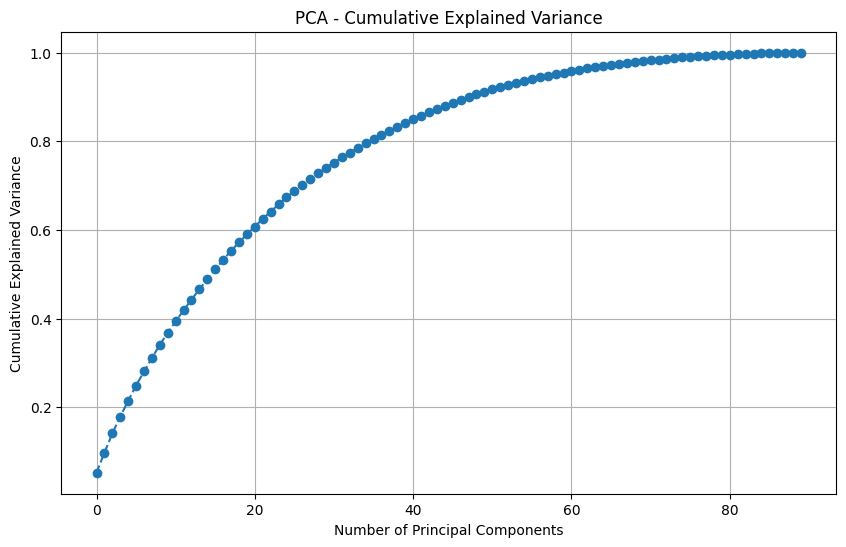

In [95]:
explained_variance_corr, loadings_corr, features_corr = process_PCA(reduced_data_corr)

In [96]:
# Create a DataFrame for the loadings
loading_df_corr = pd.DataFrame(loadings_corr.T, columns=[f'PC{i+1}' for i in range(loadings_corr.shape[0])], index=features_corr.columns)
loading_df_corr

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC81,PC82,PC83,PC84,PC85,PC86,PC87,PC88,PC89,PC90
range_delay,,,,,,,,,,,,,,,,,,,,,
13_10000_mean_lower,0.144055,0.062553,0.082774,0.157758,-0.050073,0.213990,-0.006223,-0.085149,-0.121383,-0.006591,...,0.102241,0.109321,-0.003373,-0.025390,0.122092,-0.031236,-0.062466,0.013686,0.007799,0.082297
13_16800_mean_lower,0.092707,-0.003566,0.085341,0.023776,-0.135421,-0.095865,-0.105504,0.142741,-0.024319,0.106505,...,0.072096,-0.040844,0.052849,0.015886,0.038045,0.088297,-0.105343,-0.199602,0.020676,-0.057705
13_3000_mean_lower,0.157220,0.118238,0.160997,0.002743,0.082170,0.050500,-0.203135,0.017375,-0.000510,0.014086,...,-0.140781,0.209982,0.032659,0.009749,0.042022,0.016480,0.090962,0.009165,-0.201740,0.070293
13_6000_mean_lower,0.085425,0.074770,0.145375,0.117410,0.040776,0.141782,-0.183552,0.071720,-0.008855,-0.040561,...,-0.093067,-0.225194,-0.070060,-0.039023,0.060336,-0.087124,0.163976,0.011384,-0.014231,-0.043603
13_8000_mean_lower,0.168251,0.133316,0.114266,0.202080,-0.054132,0.061926,-0.041151,0.074298,0.004820,-0.015757,...,-0.007655,-0.024456,0.026060,0.119608,-0.062050,0.030852,-0.273352,-0.081359,-0.029744,-0.117121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53_10000_mean_upper,-0.025543,0.196469,0.012146,-0.025514,0.102835,-0.109886,-0.114635,-0.166145,-0.111596,0.020418,...,0.004215,0.009980,-0.092383,0.092320,-0.077466,-0.143329,0.072466,-0.174132,0.023730,-0.016755
53_16800_mean_upper,0.121209,0.062795,0.057241,-0.058760,-0.086881,-0.113016,0.092125,0.077462,-0.111468,0.213713,...,0.191151,-0.028460,-0.132343,0.031414,-0.003188,0.058551,0.133928,-0.063567,0.063546,-0.044923
53_3000_mean_upper,0.127791,0.041824,-0.084446,0.151914,0.186274,-0.079679,-0.030757,-0.096262,0.029034,0.043859,...,0.207404,0.059967,0.008734,-0.078483,0.022969,-0.136690,-0.042067,0.081852,-0.105626,0.034319


In [97]:
# Determine the number of components to retain 90% variance
cumulative_variance = np.cumsum(explained_variance_corr)
num_components = np.argmax(cumulative_variance >= 0.9) + 1

# Get the loadings for the selected components
selected_loadings_corr = loadings_corr[:num_components, :]

# Calculate the importance of each feature by summing the absolute values of its loadings across the selected components
feature_importance_corr = np.sum(np.abs(selected_loadings_corr), axis=0)

# Create a DataFrame for feature importance
feature_importance_df_corr = pd.DataFrame({'Feature': features_corr.columns, 'Importance': feature_importance_corr})

# Sort the features by importance
feature_importance_df_corr = feature_importance_df_corr.sort_values(by='Importance', ascending=False)

# Select the top N features (e.g., top 10 features)
top_features_corr = feature_importance_df_corr.head(200)

top_features_corr

,Feature,Importance
56,23_16800_mean_upper,4.798267
13,23_6000_mean_lower,4.597680
59,23_8000_mean_upper,4.533043
75,43_10000_mean_upper,4.519115
45,13_10000_mean_upper,4.514199
...,...,...
8,18_6000_mean_lower,3.612230
23,33_6000_mean_lower,3.585354
31,43_16800_mean_lower,3.584874
77,43_3000_mean_upper,3.560861


In [98]:
# Plot the PCA interactive plot
plot_pca_interactive(reduced_data_corr, sensor_id_col='Sensor ID', n_components=2)

## Clustering

In [99]:
from sklearn.cluster import KMeans

# Apply PCA
pca = PCA(n_components=3)
principal_components = pca.fit_transform(reduced_data_corr.drop(columns=['Sensor ID']))
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
principal_df['Sensor ID'] = reduced_data_corr['Sensor ID']

# Apply K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
principal_df['Cluster'] = kmeans.fit_predict(principal_df[['PC1', 'PC2', 'PC3']])

# Create an interactive 3D scatter plot
fig = px.scatter_3d(
    principal_df,
    x='PC1',
    y='PC2',
    z='PC3',
    color='Cluster',
    symbol='Sensor ID',
    title='K-Means Clustering of Sensors Using PCA',
    labels={'PC1': 'Principal Component 1', 'PC2': 'Principal Component 2', 'PC3': 'Principal Component 3'},
    hover_data=['Sensor ID']
)

fig.show()

/Users/jihoonchung/anaconda3/envs/datascience/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



# Retain Features that previously existed

In [100]:
df_range_delay_all.head()

range_delay,Sensor ID,13_10000_mean_middle,13_16800_mean_middle,13_3000_mean_middle,13_6000_mean_middle,13_8000_mean_middle,18_10000_mean_middle,18_16800_mean_middle,18_3000_mean_middle,18_6000_mean_middle,...,48_10000_mean_upper,48_16800_mean_upper,48_3000_mean_upper,48_6000_mean_upper,48_8000_mean_upper,53_10000_mean_upper,53_16800_mean_upper,53_3000_mean_upper,53_6000_mean_upper,53_8000_mean_upper
0,1,827.00,827.000000,827.00,827.00,827.00,1071.000000,1069.285714,1069.240000,1069.400000,...,2795.000000,0.0,2809.4,2803.000000,2800.333333,2995.545455,0.0,2995.444444,3039.727273,3004.043478
1,2,679.64,679.000000,679.00,679.00,679.00,943.000000,954.200000,967.260870,954.520000,...,2669.521739,0.0,0.0,0.000000,2691.000000,0.000000,2371.0,0.000000,2951.744186,0.000000
2,3,717.88,717.727273,718.04,717.24,718.04,1029.933333,1020.920000,1007.000000,1005.960000,...,0.000000,0.0,2743.0,2727.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,4,737.08,736.840000,737.16,736.92,736.68,1030.351351,1031.000000,1028.840000,1087.000000,...,0.000000,0.0,0.0,2755.195122,0.000000,3000.000000,3019.0,3000.116279,2999.930233,3000.116279
4,5,743.00,742.894737,741.88,743.00,743.00,1046.102041,1045.697674,1047.244898,1046.288889,...,0.000000,2755.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


In [101]:
# Group the merged data by 'Sensor ID'
grouped_data = df_data_v4_1_1.groupby("Sensor ID")

# Function to get unique values of categorical columns for each group
def get_unique_categorical_values(group):
    unique_values = {}
    for column in group.select_dtypes(include=['object']).columns:
        unique_values[column] = group[column].unique().tolist()
    return unique_values

# Apply the function to each group and collect the results
unique_categorical_values = grouped_data.apply(get_unique_categorical_values).to_dict()

unique_categorical_values

/var/folders/9b/zsztmz7j6v92l4fdx69q5pxh0000gn/T/ipykernel_48813/2083575612.py:12: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



{1: {'Color of sensor': ['b'],
  'Sensor Configuration': ['HTR'],
  'Surface material': ['wood']},
 2: {'Color of sensor': ['b'],
  'Sensor Configuration': ['HTR'],
  'Surface material': ['wood']},
 3: {'Color of sensor': ['b'],
  'Sensor Configuration': ['HTR'],
  'Surface material': ['wood']},
 4: {'Color of sensor': ['g'],
  'Sensor Configuration': ['HTR'],
  'Surface material': ['wood']},
 5: {'Color of sensor': ['b'],
  'Sensor Configuration': ['HTR'],
  'Surface material': ['wood']},
 6: {'Color of sensor': ['b'],
  'Sensor Configuration': ['HTR'],
  'Surface material': ['wood']},
 7: {'Color of sensor': ['b'],
  'Sensor Configuration': ['HTR'],
  'Surface material': ['wood']},
 8: {'Color of sensor': ['g'],
  'Sensor Configuration': ['HTR'],
  'Surface material': ['wood']},
 9: {'Color of sensor': ['g'],
  'Sensor Configuration': ['HTR'],
  'Surface material': ['wood']},
 10: {'Color of sensor': ['b'],
  'Sensor Configuration': ['HTR'],
  'Surface material': ['wood']},
 11: {'Co

In [102]:
unique_categorical_values_df = pd.DataFrame.from_dict(unique_categorical_values, orient='index')

# Convert list values to strings and keep Sensor ID as index
unique_categorical_values_df = unique_categorical_values_df.applymap(lambda x: x[0] if isinstance(x, list) else x)
unique_categorical_values_df.reset_index(inplace=True)

# Rename the 'index' column to 'Sensor ID'
unique_categorical_values_df.rename(columns={'index': 'Sensor ID'}, inplace=True)

# Display the updated DataFrame
unique_categorical_values_df.head()

/var/folders/9b/zsztmz7j6v92l4fdx69q5pxh0000gn/T/ipykernel_48813/718001310.py:4: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



,Sensor ID,Color of sensor,Sensor Configuration,Surface material
0,1,b,HTR,wood
1,2,b,HTR,wood
2,3,b,HTR,wood
3,4,g,HTR,wood
4,5,b,HTR,wood


In [103]:
# One-hot encode all the object features
if not unique_categorical_values_df.empty:
    unique_categorical_values_encoded = pd.get_dummies(unique_categorical_values_df, drop_first=True)
else:
    unique_categorical_values_encoded = unique_categorical_values_df


# Convert boolean columns to integers (0 and 1)
unique_categorical_values_encoded["Color of sensor_g"] = unique_categorical_values_encoded["Color of sensor_g"].astype(int)
unique_categorical_values_encoded

,Sensor ID,Color of sensor_g,Color of sensor_g5
0,1,0,False
1,2,0,False
2,3,0,False
3,4,1,False
4,5,0,False
...,...,...,...
119,121,0,True
120,122,0,True
121,123,0,True
122,124,0,True


In [104]:
# Merge the unique categorical values DataFrame with the original data on 'Sensor ID'
df_all = pd.merge(df_range_delay_all, unique_categorical_values_encoded, on='Sensor ID', how='left')
df_all.head()

,Sensor ID,13_10000_mean_middle,13_16800_mean_middle,13_3000_mean_middle,13_6000_mean_middle,13_8000_mean_middle,18_10000_mean_middle,18_16800_mean_middle,18_3000_mean_middle,18_6000_mean_middle,...,48_3000_mean_upper,48_6000_mean_upper,48_8000_mean_upper,53_10000_mean_upper,53_16800_mean_upper,53_3000_mean_upper,53_6000_mean_upper,53_8000_mean_upper,Color of sensor_g,Color of sensor_g5
0,1,827.00,827.000000,827.00,827.00,827.00,1071.000000,1069.285714,1069.240000,1069.400000,...,2809.4,2803.000000,2800.333333,2995.545455,0.0,2995.444444,3039.727273,3004.043478,0,False
1,2,679.64,679.000000,679.00,679.00,679.00,943.000000,954.200000,967.260870,954.520000,...,0.0,0.000000,2691.000000,0.000000,2371.0,0.000000,2951.744186,0.000000,0,False
2,3,717.88,717.727273,718.04,717.24,718.04,1029.933333,1020.920000,1007.000000,1005.960000,...,2743.0,2727.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0,False
3,4,737.08,736.840000,737.16,736.92,736.68,1030.351351,1031.000000,1028.840000,1087.000000,...,0.0,2755.195122,0.000000,3000.000000,3019.0,3000.116279,2999.930233,3000.116279,1,False
4,5,743.00,742.894737,741.88,743.00,743.00,1046.102041,1045.697674,1047.244898,1046.288889,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0,False


# Upper and Lower bound's Frequency (Feature Engineering)

In [105]:
# Group by 'Sensor ID' and 'Delay (us)' for lower quartile
grouped_lower_outliers = df_lower_quartile.groupby(['Sensor ID', 'Delay (us)'])['Ping Time (us)'].count().reset_index()

# Group by 'Sensor ID' and 'Delay (us)' for upper quartile
grouped_upper_outliers = df_upper_quartile.groupby(['Sensor ID', 'Delay (us)'])['Ping Time (us)'].count().reset_index()

# Merge the grouped dataframes with alias column names for the count columns
df_outlier_freq = pd.merge(grouped_lower_outliers, grouped_upper_outliers, on=['Sensor ID', 'Delay (us)'], suffixes=('_lower', '_upper'), how='left')

# Rename the columns if necessary
df_outlier_freq.rename(columns={
    'Ping Time (us)_lower': 'Lower Quartile Ping Count',
    'Ping Time (us)_upper': 'Upper Quartile Ping Count'
}, inplace=True)


# Replace NaN values with 0
df_outlier_freq.fillna(0, inplace=True)

df_outlier_freq['Lower Quartile Ping Count'] = df_outlier_freq['Lower Quartile Ping Count'].astype(int)
df_outlier_freq['Upper Quartile Ping Count'] = df_outlier_freq['Upper Quartile Ping Count'].astype(int)


# Display the resulting DataFrame
df_outlier_freq.head()

,Sensor ID,Delay (us),Lower Quartile Ping Count,Upper Quartile Ping Count
0,1,3000,140,131
1,1,6000,171,182
2,1,8000,167,197
3,1,10000,267,258
4,1,16800,102,105


In [106]:
df_outlier_freq['delay_freq'] =  "delay"+ '_' + df_outlier_freq['Delay (us)'].astype(str)+'_'+"freq"+'_'+"lower"

# Step 3: Pivot the table
df_pivot_lower = df_outlier_freq.pivot(index='Sensor ID', columns='delay_freq', values='Lower Quartile Ping Count').reset_index()

df_pivot_lower.head()

delay_freq,Sensor ID,delay_10000_freq_lower,delay_16800_freq_lower,delay_3000_freq_lower,delay_6000_freq_lower,delay_8000_freq_lower
0,1,267.0,102.0,140.0,171.0,167.0
1,2,174.0,55.0,129.0,164.0,131.0
2,3,5.0,6.0,48.0,10.0,8.0
3,4,42.0,136.0,76.0,148.0,41.0
4,5,98.0,22.0,95.0,130.0,137.0


In [107]:
df_outlier_freq['delay_freq'] =  "delay"+ '_' + df_outlier_freq['Delay (us)'].astype(str)+'_'+"freq"+'_'+"upper"

# Step 3: Pivot the table
df_pivot_upper = df_outlier_freq.pivot(index='Sensor ID', columns='delay_freq', values='Upper Quartile Ping Count').reset_index()

df_pivot_upper.head()

delay_freq,Sensor ID,delay_10000_freq_upper,delay_16800_freq_upper,delay_3000_freq_upper,delay_6000_freq_upper,delay_8000_freq_upper
0,1,258.0,105.0,131.0,182.0,197.0
1,2,172.0,59.0,143.0,194.0,145.0
2,3,21.0,13.0,52.0,8.0,11.0
3,4,57.0,127.0,90.0,150.0,49.0
4,5,91.0,13.0,82.0,139.0,128.0


In [108]:
df_delay_freq = pd.merge(df_pivot_lower,df_pivot_upper, on='Sensor ID',how='left')
# Replace NaN values with 0
df_delay_freq.fillna(0, inplace=True)
df_delay_freq = df_delay_freq.astype(int)

df_delay_freq

delay_freq,Sensor ID,delay_10000_freq_lower,delay_16800_freq_lower,delay_3000_freq_lower,delay_6000_freq_lower,delay_8000_freq_lower,delay_10000_freq_upper,delay_16800_freq_upper,delay_3000_freq_upper,delay_6000_freq_upper,delay_8000_freq_upper
0,1,267,102,140,171,167,258,105,131,182,197
1,2,174,55,129,164,131,172,59,143,194,145
2,3,5,6,48,10,8,21,13,52,8,11
3,4,42,136,76,148,41,57,127,90,150,49
4,5,98,22,95,130,137,91,13,82,139,128
...,...,...,...,...,...,...,...,...,...,...,...
119,121,39,3,96,123,50,63,8,96,136,45
120,122,55,7,17,50,143,55,8,9,52,125
121,123,86,91,92,168,102,93,92,110,179,92
122,124,50,45,51,134,132,53,72,44,135,124


In [109]:
# Merge the unique categorical values DataFrame with the original data on 'Sensor ID'
df_all = pd.merge(df_all, df_delay_freq, on='Sensor ID', how='left')
df_all.head()

,Sensor ID,13_10000_mean_middle,13_16800_mean_middle,13_3000_mean_middle,13_6000_mean_middle,13_8000_mean_middle,18_10000_mean_middle,18_16800_mean_middle,18_3000_mean_middle,18_6000_mean_middle,...,delay_10000_freq_lower,delay_16800_freq_lower,delay_3000_freq_lower,delay_6000_freq_lower,delay_8000_freq_lower,delay_10000_freq_upper,delay_16800_freq_upper,delay_3000_freq_upper,delay_6000_freq_upper,delay_8000_freq_upper
0,1,827.00,827.000000,827.00,827.00,827.00,1071.000000,1069.285714,1069.240000,1069.400000,...,267,102,140,171,167,258,105,131,182,197
1,2,679.64,679.000000,679.00,679.00,679.00,943.000000,954.200000,967.260870,954.520000,...,174,55,129,164,131,172,59,143,194,145
2,3,717.88,717.727273,718.04,717.24,718.04,1029.933333,1020.920000,1007.000000,1005.960000,...,5,6,48,10,8,21,13,52,8,11
3,4,737.08,736.840000,737.16,736.92,736.68,1030.351351,1031.000000,1028.840000,1087.000000,...,42,136,76,148,41,57,127,90,150,49
4,5,743.00,742.894737,741.88,743.00,743.00,1046.102041,1045.697674,1047.244898,1046.288889,...,98,22,95,130,137,91,13,82,139,128


# Add Variability (Feature Engineering)

In [110]:

def create_range_delay_feature_variability(df_quartile,bound):
    # Step 1: Group and calculate mean
    df_grouped = df_quartile.groupby(['Sensor ID', 'Range (cm)', 'Delay (us)'])['Ping Time (us)'].var().reset_index()

    # Step 2: Create `range_delay` column
    df_grouped['range_delay_var'] = df_grouped['Range (cm)'].astype(str) + '_' + df_grouped['Delay (us)'].astype(str)+'_'+'var'+'_'+bound

    # Step 3: Pivot the table
    df_pivot = df_grouped.pivot(index='Sensor ID', columns='range_delay_var', values='Ping Time (us)').reset_index()
    
    return df_pivot


def feature_engineering_quartile_var(df):
    df_middle_quartile, df_lower_quartile, df_upper_quartile = split_quartiles(df)
    df_range_delay_middle = create_range_delay_feature_variability(df_middle_quartile,"middle")
    df_range_delay_lower = create_range_delay_feature_variability(df_lower_quartile,"lower")
    df_range_delay_upper = create_range_delay_feature_variability(df_upper_quartile,"upper")

    # List of DataFrames
    df_pivots = [df_range_delay_middle, df_range_delay_lower, df_range_delay_upper]

    # Initialize the merged DataFrame with the first DataFrame in the list
    df_range_delay_all = df_pivots[0]

    # Iteratively merge each DataFrame in the list
    for df in df_pivots[1:]:
        df_range_delay_all = df_range_delay_all.merge(df, on='Sensor ID')
        
    # Replace all NaN values with 0 in the merged DataFrame
    df_range_delay_all.fillna(0, inplace=True)

    return df_range_delay_all, df_range_delay_middle, df_range_delay_lower,df_range_delay_upper
    

df_range_delay_var_all,df_range_delay_var_middle, df_range_delay_var_lower,df_range_var_delay_upper = feature_engineering_quartile_var(df_data_v4_1_1)


In [111]:
df_range_delay_var_all.head()

range_delay_var,Sensor ID,13_10000_var_middle,13_16800_var_middle,13_3000_var_middle,13_6000_var_middle,13_8000_var_middle,18_10000_var_middle,18_16800_var_middle,18_3000_var_middle,18_6000_var_middle,...,48_10000_var_upper,48_16800_var_upper,48_3000_var_upper,48_6000_var_upper,48_8000_var_upper,53_10000_var_upper,53_16800_var_upper,53_3000_var_upper,53_6000_var_upper,53_8000_var_upper
0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.333333,8.594286,6.530612,...,0.000000,0.0,172.8,288.000000,165.333333,1.928118,0.0,1.616162,137.018182,362.975845
1,2,5.459592,0.000000,0.000000,0.000000,0.000000,0.000000,189.387755,7.397101,164.336327,...,36.521739,0.0,0.0,0.000000,11.636364,0.000000,144840.0,0.000000,4.004430,0.000000
2,3,4.597551,5.040169,4.937143,6.635102,6.243265,4.654545,136.646531,0.000000,7.712653,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,4,4.075102,6.014694,5.361633,5.381224,5.936327,3.123123,0.000000,6.014694,35.096774,...,0.000000,0.0,0.0,1.560976,0.000000,3.069767,0.0,3.295681,2.923588,3.295681
4,5,0.000000,6.475107,5.250612,0.000000,0.000000,8.843537,8.168328,8.272109,5.301010,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


In [112]:
# Merge the unique categorical values DataFrame with the original data on 'Sensor ID'
df_all = pd.merge(df_all, df_range_delay_var_all, on='Sensor ID', how='left')
df_all.head()

,Sensor ID,13_10000_mean_middle,13_16800_mean_middle,13_3000_mean_middle,13_6000_mean_middle,13_8000_mean_middle,18_10000_mean_middle,18_16800_mean_middle,18_3000_mean_middle,18_6000_mean_middle,...,48_10000_var_upper,48_16800_var_upper,48_3000_var_upper,48_6000_var_upper,48_8000_var_upper,53_10000_var_upper,53_16800_var_upper,53_3000_var_upper,53_6000_var_upper,53_8000_var_upper
0,1,827.00,827.000000,827.00,827.00,827.00,1071.000000,1069.285714,1069.240000,1069.400000,...,0.000000,0.0,172.8,288.000000,165.333333,1.928118,0.0,1.616162,137.018182,362.975845
1,2,679.64,679.000000,679.00,679.00,679.00,943.000000,954.200000,967.260870,954.520000,...,36.521739,0.0,0.0,0.000000,11.636364,0.000000,144840.0,0.000000,4.004430,0.000000
2,3,717.88,717.727273,718.04,717.24,718.04,1029.933333,1020.920000,1007.000000,1005.960000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,4,737.08,736.840000,737.16,736.92,736.68,1030.351351,1031.000000,1028.840000,1087.000000,...,0.000000,0.0,0.0,1.560976,0.000000,3.069767,0.0,3.295681,2.923588,3.295681
4,5,743.00,742.894737,741.88,743.00,743.00,1046.102041,1045.697674,1047.244898,1046.288889,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


In [113]:
df_all["Sensor ID"].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125])

# Export data

In [114]:
#df_all.to_csv("../processed_data/data_v4-1-1_feature_engineered.csv", index=False)